In [ ]:
!pip install numpy --upgrade

     |████████████████████████████████| 15.7 MB 55 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# 텐서플로우 일일 빌드버전

!pip install -q tf-nightly

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pathlib를 통해 경로관리 편하게

import pathlib

path = pathlib.Path('/content/drive/MyDrive/T1_PJ/DATA/모델테스트 폴더')

In [ ]:
# 해당경로 하위에 있는 jpg 파일 개수 알아보기

image_count = len(list(path.glob('*/*.jpg')))
print(image_count)

778


In [ ]:
# 해당위치의 첫번째 데이터

#PET = list(path.glob('재활용가능 어그멘테이션/*'))
#PIL.Image.open(str(PET[0]))

In [ ]:
#PIL.Image.open(str(PET[1]))

In [ ]:
# 배치사이즈, 이미지 사이즈 설정

batch_size = 16
img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 778 files belonging to 2 classes.
Using 623 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 778 files belonging to 2 classes.
Using 155 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['재활용가능 어그멘테이션', '재활용불가능 어그멘테이션']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# 정규화 작업

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# 정규화 작업

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [ ]:
# 어그멘테이션

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

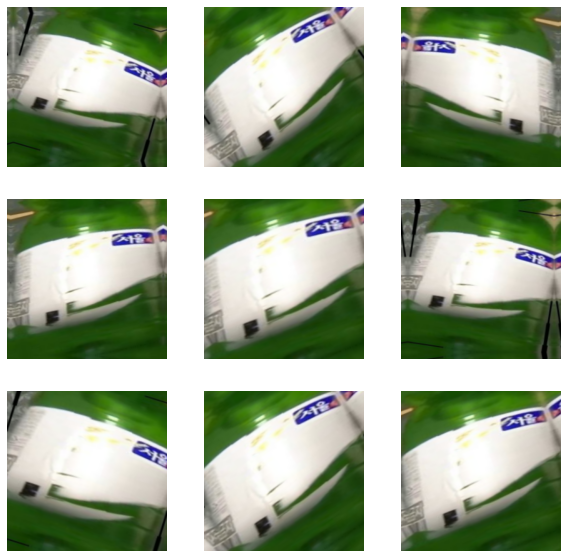

In [ ]:
# 어그멘테이션

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# 모델 작성
# Dropout 사용

num_classes = 2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [ ]:
# 훈련

epochs=30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
39/39 [==============================] - 68s 2s/step - loss: 1.0389 - accuracy: 0.5778 - val_loss: 0.6597 - val_accuracy: 0.5484
Epoch 2/30
39/39 [==============================] - 45s 1s/step - loss: 0.5876 - accuracy: 0.6758 - val_loss: 0.5215 - val_accuracy: 0.7097
Epoch 3/30
39/39 [==============================] - 45s 1s/step - loss: 0.4520 - accuracy: 0.7833 - val_loss: 0.9098 - val_accuracy: 0.6839
Epoch 4/30
39/39 [==============================] - 45s 1s/step - loss: 0.3768 - accuracy: 0.8395 - val_loss: 0.5310 - val_accuracy: 0.7032
Epoch 5/30
39/39 [==============================] - 45s 1s/step - loss: 0.3278 - accuracy: 0.8491 - val_loss: 0.4760 - val_accuracy: 0.8323
Epoch 6/30
39/39 [==============================] - 45s 1s/step - loss: 0.3317 - accuracy: 0.8571 - val_loss: 0.4867 - val_accuracy: 0.7935
Epoch 7/30
39/39 [==============================] - 45s 1s/step - loss: 0.2974 - accuracy: 0.8780 - val_loss: 0.5583 - val_accuracy: 0.8000
Epoch 8/30
39/39 [==

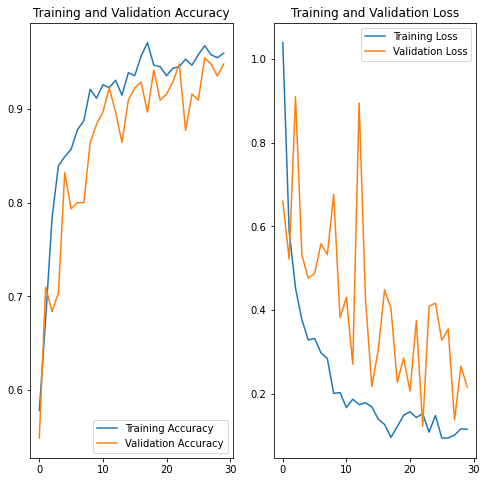

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

이 사진은 99.9481737613678% 확률로 재활용가능 어그멘테이션 입니다


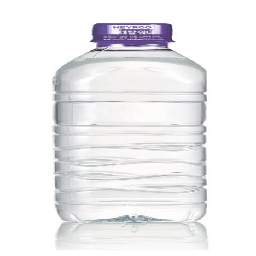

In [ ]:
# 예측1


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet8.jpg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

이 사진은 100.0% 확률로 재활용불가능 어그멘테이션 입니다


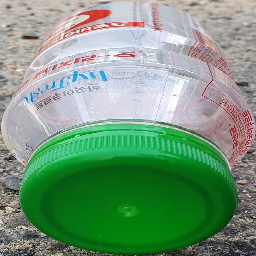

In [ ]:
# 예측2


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet2.jpg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

이 사진은 88.89390826225281% 확률로 재활용가능 어그멘테이션 입니다


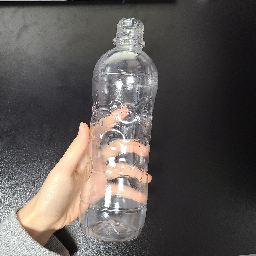

In [ ]:
# 예측


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet9.jpeg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

In [ ]:
# 모델 저장
!pip install pyyaml h5py

In [ ]:
model.save('/content/drive/MyDrive/T1_PJ/CODE/PET_model_V3.h5') 